# Assignment 4
## COGS 189: Brain Computer Interfaces
## Winter 23, Instructor: Alessandro D'Amico
### Due Date: 13Feb2023
#### This assignment was translated from MATLAB → Python/ipynb by:
* Teng "Simon" Fei https://github.com/simonfei123/cogs189wi20
* Eena Kosik
* Srinivas "Srini" Ravishankar
* Quirine "Q" van Engen
<br>
<br>

For an older MATLAB version, see: https://github.com/desa-lab/cogs189wi21/tree/main/A3
***
## Overview
Now that we have processed a competition P300 speller dataset, we will tackle another common and attractive form of BCI control: motor imagery. We will be going through the analysis of 2-class (left/right hand) motor imagery, but the data we will be working with originally contained 4-classes of data. If you are interested in extending this analysis to the 4 classes or doing something similar for your final project, this assignment will benefit you greatly. We will spatially filter the data using common spatial patterns (CSP) and use a filter bank approach to classify the data using linear discriminant analysis (LDA).


These questions will be answered with the accompanying Gradescope assignment. This assignment was created in a way that you should answer each question as it is presented to you. Please do not forget to submit every answer independently within Gradescope to ensure you do not lose any of your work.

## Section 1: Loading and Understanding the Data and Cross Validation

The data we're working with have been chopped up in a weird way so that we could host them on GitHub. By executing the following two cells of code, we will load in the data and our necessary utility functions. If you're curious about the purpose/functionality of any of the code, we encourage inspecting the source files and asking questions!

In [ ]:
!python mat2pkl.py
print('Done!')

In [ ]:
import numpy as np
from util import *
DIR, loc, EEG_eval, EEGL_eval, EEGR_eval, EEGL_train, EEGR_train = A3Load()

### Section 1.1: Description of Data

Now that the data are loaded, we can discuss what they mean, where they’re from, and what we’ll do with them.

We will be working with data from [BCI Competition IV](https://urldefense.com/v3/__https://www.bbci.de/competition/iv/__;!!Mih3wA!DBk0A3jD01IeJKxhJF7EaSiZ-jvU2PNm4SxfR5R1pCqhioQm3ekZnK5rytimmJA-vueAHHhz828PLQvC4Nhxjg$ ) data, specifically Dataset 2a which is a 4-class motor imagery design.

For simplicity, we will only be using two of the classes: left and right hand. The participants were shown 4 different stimuli in the form of an arrow pointing up, down, left or right (↑↓→←) and were instructed to imagine the corresponding motor movement. Data was recorded from 9 subjects over 22 electrodes. Each subject saw a total of 288 trials within their session which means 72 trials per class.


The data you have downloaded and loaded into this notebook has already been processed and segmented. Here are the pre-processing steps:

* We define 11 passbands which we will filter our data with:
    * [1, 3], [2, 5], [4, 7], [6, 10], [7, 12], [10, 15], [12, 19], [15, 25], [19, 30], [25, 35], and [30, 40] Hz

* We then loop the following procedure over all users using all 11 passbands:

    * Filter the continuous data (windowed sinc FIR filter)
    * Epoch left-hand data from [-300ms 2500ms] locked to visual cue
    * Epoch right-hand data from [-300ms 2500ms] locked to visual cue 

* The filtered data were then segmented into a train and eval set before being exported
    * The train set consists of 72 trials and labeled eval consists of 60 trials per class

### Section 1.2: K-Fold Cross Validation

Cross validation (cv) is a technique which allows you to train a classifier on a subset of your data and test it on a different subset. It is extremely important to ensure your training and testing data have no mutual samples as this will lead to overfitting your model. K-Fold cv allows you to run this procedure using multiple unique chunks of your data. For example, let’s imagine a hypothetical scenario where we have 5 data points:
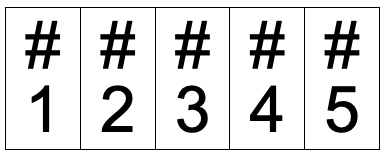

If we wanted to train a classifier using 4/5ths of the data and validate the classifier’s performance using 1/5th of the data, we could simply select 1-4 for training and 5 for validation:

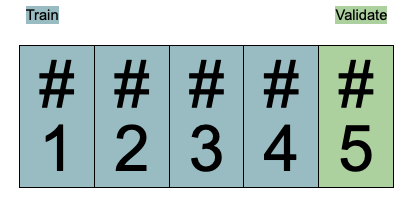

However, it is possible that this may not be a very descriptive test. If the later portions of the data contain some variation not present in the earlier portion of the data, we may get poor classification results. It is also not a very statistically impressive test to only train on one part of the data and test on only one part of the data.

K-fold cv allows us to split the data into ‘folds’ which we can use to vary which part of the data is being trained on and which section is being tested on. Our hypothetical example can be considered 5-fold cv and we could write some code to go through the 5 permutations rather trivially. In fact, let’s do this!

***
**Question 1:** Create a for loop which takes `Q1_data` and do the following:
1. Iterate through every point in `Q1_data`
2. Store every value that is **not the current value of the iteration** (i.e. all values that are not `i`) into a list
3. Append that list to the list `Q1_ANS`


**It is critical that you save your list of lists as the variable `Q1_ANS` as this will be autograded**
***

In [ ]:
# Goal: Create a 5-fold "CV" loop
Q1_data = [0, 1, 2, 3, 4]
Q1_ANS = []

# You may find the following line of code useful:
i = 0
print([x for x in Q1_data if i != x])

# --- Question 1 ---
# WRITE YOUR FOR LOOP HERE
# WRITE YOUR FOR LOOP HERE
# WRITE YOUR FOR LOOP HERE

The code we wrote for Q1 is a useful starting point, but is not quite useful for cross validation just yet. For starters, we have given it ‘data’ which is perfectly divided which is atypical. Furthermore, we didn’t do anything with the ‘data’ and simply printed it out. Let’s adapt this code to be more useful. 

Let’s begin working with our actual data. EEGL/R_train and EEGL/R_eval are all $9\times11$ arrays. This is because we have 9 participants and defined 11 unique filters which we use to extract data from every session. Every index within the `_train` arrays has identical dimensionality, and every index within the `_test` arrays has identical dimensionality. We can determine the dimensionality by using the function `.shape` which will return a number of variables proportional to the number of dimensions:

In [ ]:
print(EEGR_train[0][0].shape)

Our training data dimensionality is $22\times550\times72$. This is what each of the dimensions mean:
* 0: Number of EEG channels (22)
* 1: Number of time points/samples (550)
* 2: Number of unique epochs/trials/observations (72)

Within our 72 unique trials, we would like to divide the data into `k` equal bins. Let’s use `k = 6` since there is no remainder when dividing 72 by 6 (i.e. `72 % 6 == 0`).

***
**Question 2:** When `k=6`, how many samples are in each bin?

Please write code to compute this answer rather than simply writing an answer integer value. 

Save you answer into the variable `Q2_ANS` for autograding purposes.
***

In [ ]:
Q2_ANS = 0
k = 6

# --- Question 2 ---
# WRITE YOUR CODE HERE
# WRITE YOUR CODE HERE
# WRITE YOUR CODE HERE

We could very easily divide the dataset into 6 bins sequentially and iteratively select our training and testing data. However, it is useful to randomize which samples are included temporally to avoid accidentally classifying time. In order to do this, we can create an array of indices and shuffle them. Numpy has a very useful function to create a shuffled sequential array called `np.random.permutation()`. Before we utilize this function, let’s take a bit of time to talk about  reproducability when using random number generators (RNG) like `np.random.permutation()`. Most RNG is not truly random, but rather pseudo-random. Every time you run a function which depends on RNG, your results will be different. This can make debugging and testing your code rather difficult which is why programming languages give users the ability to control which ‘seed’ of randomness is planted. In order to set the seed in python, we use the function `np.random.seed()`.

Let’s set our seed and interact with the outputs of `np.random.permutation()` and generate some random numbers:

In [ ]:
np.random.seed(189) # DO NOT CHANGE THE SEED! THIS IS CRITICAL TO AUTOGRADING!
rand_nums = np.random.permutation(6)

***
**Question 3:** What is the 3rd value (index == 2) of `rand_nums`?

Please write code to compute this answer rather than simply writing an answer integer value. 

Save you answer into the variable `Q3_ANS` for autograding purposes.
***

In [ ]:
Q3_ANS = 0

# --- Question 3 ---
# WRITE YOUR CODE HERE
# WRITE YOUR CODE HERE
# WRITE YOUR CODE HERE

Let's now create variables for our actual k-fold cross validation.

In [ ]:
n_channel, n_time, n_sample = EEGR_train[0][0].shape
randIdx = np.random.permutation(n_sample)

Our variable `randIdx` now contains a shuffled array of integers 1 to 72 inclusively. We can use these indices to select our training and validation datasets. For example, we could take the first number of samples per bin as our validation set and the rest as our training set via:

In [ ]:
k = 6
print(f'Our k is: {k}')

bin_size = int(n_sample / k)
print(f'Our bin size is: {bin_size}')

# In order to make our task easier, 
# we can reshape randIdx to have k rows and bin_size columns
# by using .reshape():
randIdx = randIdx.reshape(k, bin_size)
print(randIdx)

This will work for the first fold, but what about the others? We can make `valIdx` and `trainIdx` 2D arrays which will allow us to store the training and validation indices for every fold:

In [ ]:
trainIdx = np.zeros((k, bin_size*(k-1)))
valIdx = np.zeros((k, bin_size))

***
**Question 4:** You should now be in good shape to write a simple for loop to fill `trainIdx` and `valIdx` with their respective index values for every fold. You can verify your answer is correct using the following rules:

* For an index `i`, `trainIdx[i]` and `valIdx[i]` should never share any values
* Every row of `trainIdx` should contain `bin_size * (k-1)` indices
* Every row of `valIdx` should contain `bin_size` indices

Please use the code you’ve written and have been given previously in this assignment to give you a starting place. Feel free to search the internet for useful ways to solve this problem if necessary, but attempt to tackle it without outside help to facilitate maximal learning.

Please make sure your answers are being populated in `trainIdx` and `valIdx` for autograding purposes.
***

In [ ]:
# We'll reset trainIdx and valIdx (just in case)
# Note: feel free to use uninitialized lists and append
#       this is just one possible starting point to show
#       the correct size of these objects.
trainIdx = np.zeros((k, bin_size*(k-1))) # could also be = []
valIdx = np.zeros((k, bin_size))           # could also be = []

# --- Question 4 ---
# WRITE YOUR FOR LOOP/CODE HERE
# WRITE YOUR FOR LOOP/CODE HERE
# WRITE YOUR FOR LOOP/CODE HERE

In [ ]:
# Depending on your solution, valIdx and trainIdx may not be np.arrays
# Let's guarantee they are
valIdx = np.array(valIdx)
trainIdx = np.array(trainIdx)

# This is just here to make sure your data shapes are correct
assert valIdx.shape == (k, bin_size)
assert trainIdx.shape == (k, bin_size*(k-1))

It is important that you implement Q4 correctly as we will be utilizing those indices for the remaining steps. Luckily you can use the rules above to verify your implementation is correct before moving on.

## Section 2: Feature Extraction and Classification

Common spatial patterns (CSP) is almost exclusively used in the context of EEG research and is particularly suited for analyzing data where classes will contain spatial differences. Motor imagery tasks are particularly good candidates for CSP due to the motor and sensorimotor cortices’ segmented configuration. When a user imagines left hand motor imagery you would theoretically expect to see activity in the form of attenuated alpha (mu rhythms) on the right hemisphere and attenuated activity on the left hemisphere during right hand imagery. The electrodes over the motor cortex tend to be safe choices, but rather than making the assumption that all participants will contain the same discriminability at any given electrode site, we can use CSP to determine which electrodes discriminate the data best in order to create our spatial filters. CSP is dependent on the labels of the signals and is therefore a supervised method. The mechanism by which CSP separates the classes is through maximizing the ratio in variance between said classes. For a detailed explanation and theoretical background of CSP, please refer to the paper we read in class; [Blankertz et al., 2008](https://urldefense.com/v3/__https://ieeexplore.ieee.org/document/4408441__;!!Mih3wA!DBk0A3jD01IeJKxhJF7EaSiZ-jvU2PNm4SxfR5R1pCqhioQm3ekZnK5rytimmJA-vueAHHhz828PLQuoBaUeIg$ ). For this assignment, we iterate through our filter bank and for each passband we will choose 3 spatial filters from each class.

***
**Question 5:** Set the value of `Q5_ANS` to the number of spatial filters we choose from ***each class.*** 

*Hint: carefully read the last sentence in the above markdown section.*

The answer should just be an integer.
***

In [ ]:
Q5_ANS = 0 # Integer answer here

We will then use those filters to process our data, take the normalized log power of the filtered data and finally train a classifier using LDA. We covered LDA in detail in the previous assignment and during the lectures, but the normalized log power may be new to you. Once our spatial filters have been selected and extracted from both of our classes,  we calculate their normalized log power by computing the variance of each spatial filter (recall that variance is squared deviation which is why this is power and not magnitude), normalizing the values by dividing the mean and finally taking the log of the values for every trial.

 We will then test our classifier every iteration on our validation dataset and store the results. Due to the particular nature of the in-house code we’ll be utilizing for this process, all of the code has been provided for you. As mentioned previously, **this step is completely dependent on Q4 and Q5 being completed correctly.**

We will repeat the process above on every subject independently. It is uncommon for classifiers to perform equally well when trained on one participant and then tested on another due to the unique nature of an individual's EEG data and the latent factors underlying their origins. Good transferability of a classifier from individual to individual is an attractive facet of BCI research and a good motivation for a final project or continued research beyond this class.

After the classifier is trained on a subject using CSP and LDA on the 11 unique passband filters, we need some way to combine the results from all 11 runs. The most naive way of accomplishing this is by taking the probabilities calculated by classifying the cv data with LDA and simply computing the mean over all 11 bands per observation. We then compute the accuracy of our classification per subject.

### Run the main analysis and then answer the questions below

Do not modify the main analysis code. Please execute the following line.

**This will take a while**

In [ ]:
# Main Analysis (Do Not Modify)

# Declare useful variables
n_subjects, n_filters = EEGL_train.shape
train_size = bin_size * (k-1)
val_size = bin_size
accuracy = np.zeros((n_subjects, k))
csp_per_class = Q5_ANS
trainIdx = trainIdx.astype(int)
valIdx = valIdx.astype(int)

# Begin nested loops
# Subject > Fold > Band
print('===============')
for subject in range(n_subjects):
    print('Processing Subject {}/{}'.format(subject+1, n_subjects))
    for fold in range(k):
        print('Processing Fold {}/{}'.format(fold+1, k))
        band_score_train = np.zeros((train_size*2, n_filters))
        band_score_val = np.zeros((val_size*2, n_filters))
        for band in range(n_filters):
            # train,val dataset -> train,val for each subject&band
            L_train = EEGL_train[subject, band][:,:,trainIdx[fold]].transpose(2,0,1) # (trials, chans, samples)
            R_train = EEGR_train[subject, band][:,:,trainIdx[fold]].transpose(2,0,1) # (trials, chans, samples)
            L_val = EEGL_train[subject, band][:,:,valIdx[fold]].transpose(2,0,1) # (trials, chans, samples)
            R_val = EEGR_train[subject, band][:,:,valIdx[fold]].transpose(2,0,1) # (trials, chans, samples)
            train_data = np.stack((L_train,R_train), axis=0) # <- CSP input data format (classes, trials, chans, samples) 
            val_data = np.stack((L_val,R_val), axis=0) # <- CSP input data format (classes, trials, chans, samples)

            # Run Mahta's CSP code
            # Source: https://github.com/mahtamsv/CCACSP
            csp_filts, clf = train(train_data[0], train_data[1], csp_per_class)
            train_prob = test(np.vstack(train_data), csp_filts, clf)
            val_prob = test(np.vstack(val_data), csp_filts, clf)
            
            # test() gives the prob of the 0th class, that's why 
            # we have y_val seemingly switched below
            y_val = np.append(np.ones(12), np.zeros(12))

            band_score_train[:,band] = train_prob
            band_score_val[:,band] = val_prob
        
        
        accuracy[subject,fold] = sum(np.rint(band_score_val.mean(1))==y_val)/len(y_val)
    print('===============')
print(np.mean(accuracy, axis=1))

# Main Analysis Over

***
**Question 6:** What is the dimensionality of `csp_filts`?

Please write code to compute this answer. 
***

In [ ]:
 Q6_ANS = 0

***
**Question 7:** In `csp_filts`, are the filters defined by the rows or columns?

Set `Q7_ANS` equal to either:
* `row` if you believe the spatial filters are represented in the rows, or
* `col` if you believe the spatial filters are represented in the columns.
***

In [ ]:
row = Q6_ANS[0]
col = Q6_ANS[1]
Q7_ANS = None # set this equal to row or col

After the analysis has completed, a lot of new variables have been created. The one variable which contains a useful metric for us is the `accuracy` variable. It will be of dimensionality `n_subjects` $\times$ `k` where each row is a subject and each column is a different fold of cross validation.

***
**Question 8:** What is the mean accuracy for *each* subject?

Hint: This should generate a mean accuracy for each subject individually

Please write your answer using code rather than manually creating a list of floats.
* It is ***critical*** you head the above instruction due to how this will be autograded.
***

In [ ]:
Q8_ANS = None

# This is just here to make sure your data shape is correct
assert len(Q8_ANS) == EEGR_train.shape[0]
print(Q8_ANS)